# SailGP Data Analyst Challenge

The aim is to test you python abilities. The challenge is to analyze the data provided and answer the questions below. You can use any library you want to help you with the analysis. The data is from the SailGP event in Auckland 2025. The data is in the 'DATA' folder.

There are various sources available.

The Boat Logs are in the 'Boat_Logs' folder. The data is in csv format and the columns are described in the 'Boat_Logs/Boat_Logs_Columns.csv' file.
The 'Course_Marks_2025-01-19.csv' file contains the mark positions and wind reading on the course for the whole day.

The Race_XML folder contains the xml files for each race that contains information on where the boundaries of the course are, the theoretical position of the marks and the target racecourse axis.

The 2025-01-19_man_summary.csv file contains the metrics from the manoeuvre summary for the day.
The 2025-01-19_straight_lines.csv file contains the metrics from the straight line summary for the day.

Both are derived from the boat logs.

The 2502 m8_APW_HSB2_HSRW.kph.csv file contains the polar data for the boats in that config.

## Requierements
- Chose at least 3 questions from the list below to answer.
- Python 3.8 or higher
- Notebook should be able to run without any errors from start to finish.
- Specify the libraries (imports) used in the notebook.
- Any comments to make the notebook self-explanatory and easy to follow would be appreciated.
- If you can't get to the end of a question, we would appreciate the code you have written so far and explain what you were trying to do.

## Further information:
- We usually use bokeh for visualizations. So any showcase of bokeh would be appreciated.
-

## Submitting the results.
It would be great if you could provide a jupyter notebook with the code and the results of the analysis. You can submit the results by sharing a link to a git repository.


### Imports and re-used functions
Free section to initialize the notebook with the necessary imports and functions that will be used in the notebook.



In [54]:
#import pandas as pd
#import numpy as np
#import bokeh
#from bs4 import BeautifulSoup
#import matplotlib.pyplot as plt
#import scipy

#imports for pandas, numpy, bokeh, beautifulsoup4, matplotlib, and scipy.

## Question 1: Write a Python function that can take a compass direction (ie. TWD or Heading) and calculate an accurate mean value across a downsampled frequency. Eg. If TWD is at 1Hz, give me a 10s average.

In [55]:
import numpy as np
import pandas as pd

def circular_mean(angles):
    """
    Compute the mean of circular data.
    
    Parameters:
        angles: Angles in degrees.

    Returns:
        float: Mean angle in degrees.
    """

    #This converts degrees to radians to handle circular directions.
    angles_rad = np.radians(angles)  
    
    mean_x = np.mean(np.cos(angles_rad))
    mean_y = np.mean(np.sin(angles_rad))

    #This will compute angles in radians and then convert them back to degrees.
    mean_angle_rad = np.arctan2(mean_y, mean_x)  
    mean_angle_deg = np.degrees(mean_angle_rad)  

    #This ensures that the outputs are between 0 and 360 degrees.
    return mean_angle_deg % 360  

def downsample_data(data, frequency, downsample_interval):
    """
    Downsample the data by picking values at a specific interval.
    
    Parameters:
        data: The data that will be downsampled.
        frequency: The frequency of data being collected in Hz.
        downsample_interval: The number of seconds that will be averaged over 10 seconds.

    Returns:
        list: Downsampled data.
    """
    num_samples = int(frequency * downsample_interval)
    downsampled_data = data[::num_samples]  #This will take every 'num_samples' element in the data.
    
    return downsampled_data

def read_csv_file(file_path, column_name):
    """
    Read the HEADING data column from the data_USA csv file.
    
    Parameters:
        file_path: Path to the CSV file.
        column_name: The name of the column containing the TWD data.
        
    Returns:
        list: A list of HEADING values.
    """
    
    #This will read the data_USA csv file into a dataframe.
    df = pd.read_csv(file_path) 
    #Added this just to ensure that if the column name is not in the dataframe to let me know.
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the csv file.")
    
    #This will extract the TWD column as a list.
    compass_data = df[column_name].tolist()
    
    return compass_data

#Downsampling portion.
csv_file_path = r'/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_USA.csv'  #csv file path.
column_name = 'HEADING_deg'  #Heading column.

#This will read the HEADING data from the provided csv file.
twd_data = read_csv_file(csv_file_path, column_name)

frequency = 1  #1 Hz frequency
downsample_interval = 10  #Averaging over each 10 seconds

#This will downsample the data.
downsampled_twd_data = downsample_data(twd_data, frequency, downsample_interval)

#This will calculate the mean of the downsampled data.
mean_twd = circular_mean(downsampled_twd_data)
print(f"Mean HEADING_deg of USA SGP Team over {downsample_interval} seconds: {mean_twd:.2f}°")

Mean HEADING_deg of USA SGP Team over 10 seconds: 65.97°


This function will take a provided TWD or HEADING and calculate the average value. Then I added a continuation of the function to take the average over a downsampled frequency at 1 Hz/10 seconds. I then applied this to the Team USA's provided CSV file. This could also be modified to pull certain portions of data to analyze over a single leg or race.

## Question 2: Given a course XML and a timeseries of boat Lat/Lon values, calculate a VMC column for the same timeseries.


## Question 3: Verify and comment on the boats calibration. If possible propose a post-calibrated set of wind numbers and a potential calibration table.


## Question 4: Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
from geopy.distance import geodesic
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.palettes import Category20

output_notebook()  #This enables bokeh in Jupyter Notebook.

#This loads the boats position data.
def load_boat_positions(csv_file):
    """Load time series boat position data."""
    df = pd.read_csv(csv_file)
    df['TIME_LOCAL_unk'] = pd.to_datetime(df['TIME_LOCAL_unk'])  #this ensures timestamp format.
    return df

#This parses the course XML to find waypoints.
def parse_course_xml(xml_file):
    """Extract waypoints from a course XML."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    waypoints = []
    for wp in root.findall(".//Mark"):
        lat = float(wp.get("TargetLat"))
        lon = float(wp.get("TargetLng"))
        waypoints.append((lat, lon))
    
    return waypoints

#This computes the progress along the course.
def progress_along_course(position, waypoints):
    """Compute how far a boat has progressed along the course."""
    total_distance = 0
    print(waypoints)
    prev_wp = waypoints[0]
    
    for wp in waypoints[1:]:
        segment_dist = geodesic(prev_wp, wp).meters
        total_distance += segment_dist
        
        #This is to check if boat is in the segment.
        if geodesic(prev_wp, position).meters <= segment_dist:
            return total_distance - geodesic(prev_wp, position).meters
        
        prev_wp = wp

    return total_distance  #used only if it is past the last waypoint.

#This computes the distance to the leader.
def compute_distance_to_leader(df, waypoints):
    """Compute distance to leader for each boat at each timestamp."""
    df['progress'] = df.apply(lambda row: progress_along_course((row['LATITUDE_GPS_unk'], row['LONGITUDE_GPS_unk']), waypoints), axis=1)
    
    #This finds the leaders progress at each timestamp.
    leader_progress = df.groupby('TIME_LOCAL_unk')['progress'].max().reset_index()
    leader_progress.columns = ['TIME_LOCAL_unk', 'leader_progress']

    #This merges the dataframe and computes the distance to the leader.
    df = df.merge(leader_progress, on='TIME_LOCAL_unk')
    df['distance_to_leader'] = df['leader_progress'] - df['progress']

    return df

#This creates the visualization using bokeh.
def plot_distance_to_leader(df):
    """Plot interactive Distance to Leader over time using Bokeh."""
    p = figure(x_axis_type="datetime", width=900, height=500, title="Distance to Leader Over Time")
    p.xaxis.axis_label = "Timestamp"
    p.yaxis.axis_label = "Distance to Leader (m)"
    
    hover = HoverTool(tooltips=[("Boat", "@boat_id"), ("Distance", "@y{0,0.0}")])
    p.add_tools(hover)

    colors = Category20[11]  #color palette for 11 boats.

    for i, boat in enumerate(df['BOAT'].unique()):
        subset = df[df['BOAT'] == boat]
        p.line(subset['TIME_LOCAL_unk'], subset['distance_to_leader'], legend_label=boat, color=colors[i % len(colors)], line_width=2)
    
    p.legend.title = "Boats"
    show(p)

#These lines load each boat's data and runs the pipeline.
course_xml = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Race_XMLs/25011905_03-13-55.xml"   #Course XML data.
usa_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_USA.csv"  #USA boat.
aus_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_AUS.csv"  #AUS boat.
bra_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_BRA.csv"  #BRA boat.
can_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_CAN.csv"  #CAN boat.
den_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_DEN.csv"  #DEN boat.
esp_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_ESP.csv"  #ESP boat.
gbr_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_GBR.csv"  #GBR boat.
ger_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_GER.csv"  #GER boat.
ita_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_ITA.csv"  #ITA boat.
nzl_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_NZL.csv"  #NZL boat.
sui_boat_csv = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_SUI.csv"  #SUI boat.

waypoints = parse_course_xml(course_xml)
df = load_boat_positions(usa_boat_csv)
df_aus = load_boat_positions(aus_boat_csv)
df_bra = load_boat_positions(bra_boat_csv)
df_can = load_boat_positions(can_boat_csv)
df_den = load_boat_positions(den_boat_csv)
df_esp = load_boat_positions(esp_boat_csv)
df_gbr = load_boat_positions(gbr_boat_csv)
df_ger = load_boat_positions(ger_boat_csv)
df_ita = load_boat_positions(ita_boat_csv)
df_nzl = load_boat_positions(nzl_boat_csv)
df_sui = load_boat_positions(sui_boat_csv)

# Combine all boats
df_combined = pd.concat([df, df_aus, df_bra, df_can, df_den, df_esp, df_gbr, df_ger, df_ita, df_nzl, df_sui])

# Compute Distance to Leader
df_combined = compute_distance_to_leader(df_combined, waypoints)

# Show results
print(df_combined.head())

# Plot results
plot_distance_to_leader(df_combined)

Loading BokehJS ...

## Question 5: Given a course XML, along with a wind speed and direction and a polar, calculate the minimum number of tacks or gybes for each leg of the course and each gate mark on the leg.

## Question 6: Calculate a “tacked” set of variables depending on the tack of the boat, so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.


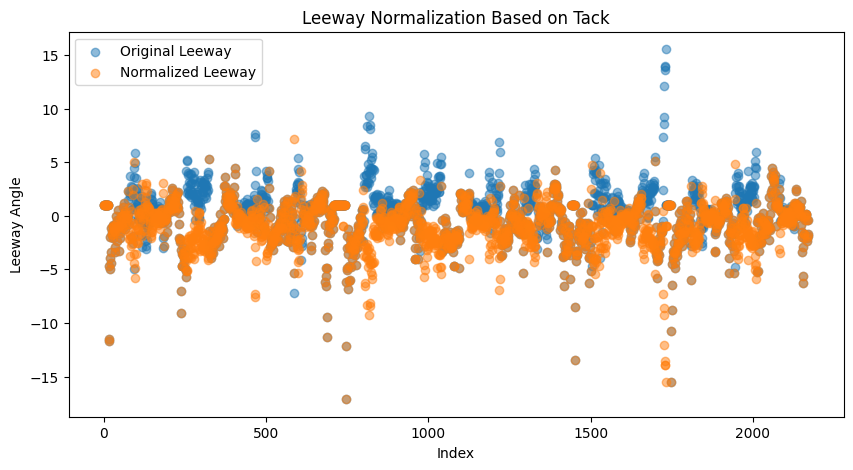

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#These lines load the data set based on the provided csv files.
file_path = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/Boat_logs/data_USA.csv"
df = pd.read_csv(file_path)

#This line determines what tack the boat is on based on the true wind angle.
df["TACK"] = df["TWA_SGP_deg"].apply(lambda x: "port" if x < 0 else "stbd")

#Defines the columns so that they are mirrored on starboard tack.
mirror_columns = ["LEEWAY_deg", "HEEL_deg", "ANGLE_DB_CANT_P_deg", "ANGLE_DB_CANT_S_deg"]

#Normalizes the dataframe to port tack reference.
def normalize_tack(df, mirror_columns):
    df = df.copy()
    for col in mirror_columns:
        if col in df.columns:
            df[col] = df.apply(lambda row: -row[col] if row["TACK"] == "stbd" else row[col], axis=1)
    return df

#Applies normalization to the mirrored dataframe.
df_normalized = normalize_tack(df, mirror_columns)

#This creates a visualization to plot the leeway before and after normalization.
plt.figure(figsize=(10, 5))
plt.scatter(df.index, df["LEEWAY_deg"], label="Original Leeway", alpha=0.5)
plt.scatter(df.index, df_normalized["LEEWAY_deg"], label="Normalized Leeway", alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Leeway Angle")
plt.legend()
plt.title("Leeway Normalization Based on Tack")
plt.show()

## Question 7: Given a set of tacks (in CSV), and train a model to explain the key features of these tacks when optimizing for vmg. Show appropriate visualisations to explain your conclusions.

RMSE: 119.39, R² Score: 0.668


/var/folders/j3/b74sw94s6xb1p53gcslfwysc0000gn/T/ipykernel_31063/3860310300.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")


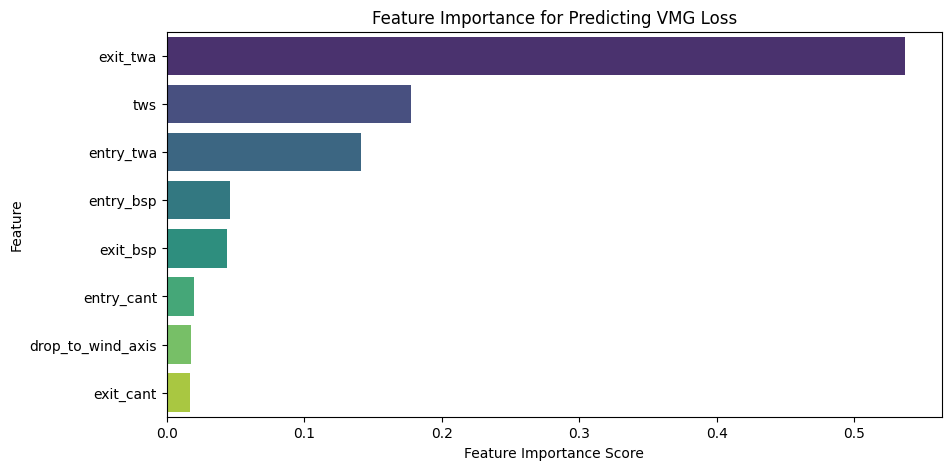

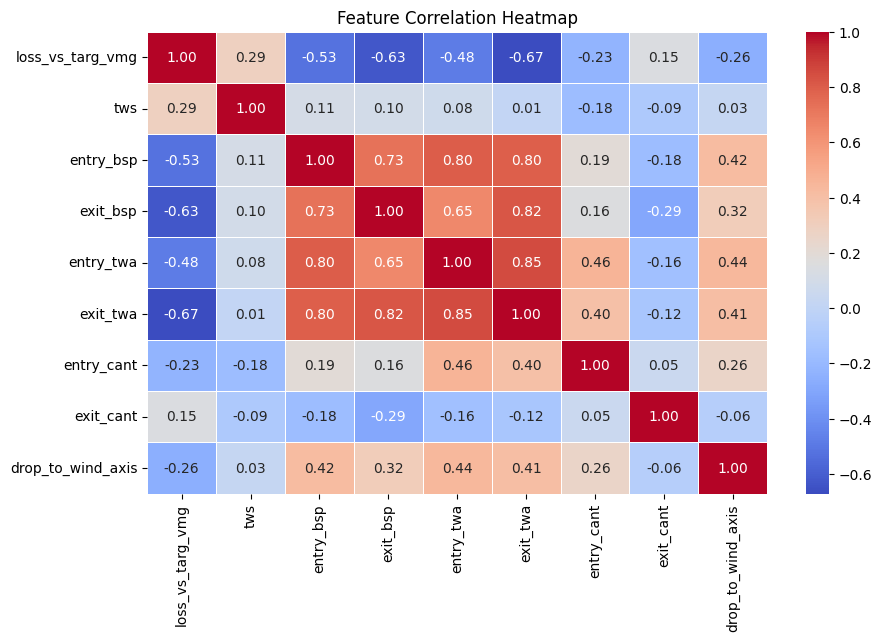

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Load the CSV file and create a dataframe with the maneuvers data.
man = "/Users/george/Desktop/Sail GP Code/SGP_Data_Challenge/Data/2025-01-19_man_summary.csv"  
df = pd.read_csv(man)

#After looking through the column titles I selected the relevant metrics.
#I chose the relevant metrics based on my technical sailing background.
metrics = [
    "loss_vs_targ_vmg",  #Choosing this as my target variable.
    "tws", "entry_bsp", "exit_bsp", "entry_twa", "exit_twa",
    "entry_cant", "exit_cant", "drop_to_wind_axis"]

#Filtering the dataframe for existing features while dropping missing values.
df_filtered = df[metrics].dropna()

#Define metrics (X) and the target variable (y).
X = df_filtered.drop(columns=["loss_vs_targ_vmg"])
y = df_filtered["loss_vs_targ_vmg"]

#Split the dataframe into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a Random Forest Regressor model.
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Create predictions and have the model evaluated.
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

#Print the results.
print(f"RMSE: {rmse:.2f}, R² Score: {r2:.3f}")

#Create the features importance visualization.
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance for Predicting VMG Loss")
plt.show()

#Create a heatmap for the metric correlation.
plt.figure(figsize=(10, 6))
sns.heatmap(df_filtered.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

The most important metric to minimize VMG loss through a maneuver as predicted by this model is the exit true wind angle. Other important metrics include the true wind speed and the true wind angle at entry. This aligns with my thoughts based on my technical sailing background.

## Question 8: Give insights on the racing on what made a team win or underperform in the race.